In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configurações para os gráficos
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

In [2]:
# Carregar a tabela de features v3 (resultado do notebook 04)
path_base = '../data/processed/feature_table_v3.parquet'
df_base = pd.read_parquet(path_base)
print(f"Tabela base carregada com {df_base.shape[0]} registros e {df_base.shape[1]} colunas.")

# Carregar os novos datasets hídricos
try:
    # Usando os nomes de arquivo que você baixou
    path_ear = '../data/EAR_DIARIO_SUBSISTEMA_2025.csv'
    df_ear_raw = pd.read_csv(path_ear, sep=';')
    
    path_ena = '../data/ENA_DIARIO_SUBSISTEMA_2025.csv'
    df_ena_raw = pd.read_csv(path_ena, sep=';')

    print("Datasets de EAR e ENA carregados.")
except FileNotFoundError as e:
    print(f"ERRO: Arquivo não encontrado - {e}")
    print("Por favor, confirme se os arquivos CSV estão na pasta /data.")
    raise

Tabela base carregada com 366 registros e 12 colunas.
Datasets de EAR e ENA carregados.


In [3]:
# --- Célula 3: Processamento - Energia Armazenada (EAR) ---

coluna_data_ear = 'ear_data'
coluna_subsistema_ear = 'nom_subsistema'
coluna_valor_ear = 'ear_verif_subsistema_percentual'

df_ear = df_ear_raw[[coluna_data_ear, coluna_subsistema_ear, coluna_valor_ear]].copy()
df_ear.rename(columns={coluna_valor_ear: 'ear_percentual_seco'}, inplace=True)

df_ear['timestamp'] = pd.to_datetime(df_ear[coluna_data_ear])

# CORREÇÃO: Usando o nome 'SUDESTE', conforme encontrado no arquivo.
df_ear_seco = df_ear[df_ear[coluna_subsistema_ear] == 'SUDESTE'].copy()

df_ear_seco.set_index('timestamp', inplace=True)

print("Feature de Energia Armazenada (EAR) foi criada.")
display(df_ear_seco.head())

Feature de Energia Armazenada (EAR) foi criada.


,ear_data,nom_subsistema,ear_percentual_seco
timestamp,,,
2025-01-01,2025-01-01,SUDESTE,51.6570
2025-01-02,2025-01-02,SUDESTE,52.2283
2025-01-03,2025-01-03,SUDESTE,52.7255
2025-01-04,2025-01-04,SUDESTE,53.2389
2025-01-05,2025-01-05,SUDESTE,53.6733


In [4]:
# --- Célula 4: Processamento - Energia Afluente (ENA) ---

coluna_data_ena = 'ena_data'
coluna_subsistema_ena = 'nom_subsistema'
coluna_valor_ena_percentual = 'ena_bruta_regiao_percentualmlt'

df_ena = df_ena_raw[[coluna_data_ena, coluna_subsistema_ena, coluna_valor_ena_percentual]].copy()
df_ena.rename(columns={coluna_valor_ena_percentual: 'ena_percentual_mlt_seco'}, inplace=True)

df_ena['timestamp'] = pd.to_datetime(df_ena[coluna_data_ena])

# CORREÇÃO: Usando o nome 'SUDESTE', conforme encontrado no arquivo.
df_ena_seco = df_ena[df_ena[coluna_subsistema_ena] == 'SUDESTE'].copy()

df_ena_seco.set_index('timestamp', inplace=True)

print("Feature de Energia Afluente (ENA) foi criada.")
display(df_ena_seco.head())

Feature de Energia Afluente (ENA) foi criada.


,ena_data,nom_subsistema,ena_percentual_mlt_seco
timestamp,,,
2025-01-01,2025-01-01,SUDESTE,97.1217
2025-01-02,2025-01-02,SUDESTE,99.7291
2025-01-03,2025-01-03,SUDESTE,101.8720
2025-01-04,2025-01-04,SUDESTE,101.7271
2025-01-05,2025-01-05,SUDESTE,101.5504


In [5]:
# Começa com a tabela base do notebook anterior
df_combinado = df_base.copy()

# Adiciona as novas features hídricas
# Selecionamos apenas a coluna de valor que nos interessa de cada dataframe
df_combinado = df_combinado.join(df_ear_seco[['ear_percentual_seco']])
df_combinado = df_combinado.join(df_ena_seco[['ena_percentual_mlt_seco']])

# Remove dias para os quais não temos dados hídricos (se houver)
df_combinado.dropna(inplace=True)

print("Tabela final combinada (Alvo + Carga + Geração + Rede + Hídrica):")
display(df_combinado.head())

Tabela final combinada (Alvo + Carga + Geração + Rede + Hídrica):


,deficit_diario_mwh,nivel_risco,programada,verificada,diferenca_verif_prog,geracao_total_diaria_go,geracao_fotovoltaica_diaria,geracao_hidroelétrica_diaria,geracao_térmica_diaria,fator_cap_solar_medio_seco,total_mwh_restrito_go,saldo_intercambio_seco,ear_percentual_seco,ena_percentual_mlt_seco
timestamp,,,,,,,,,,,,,,


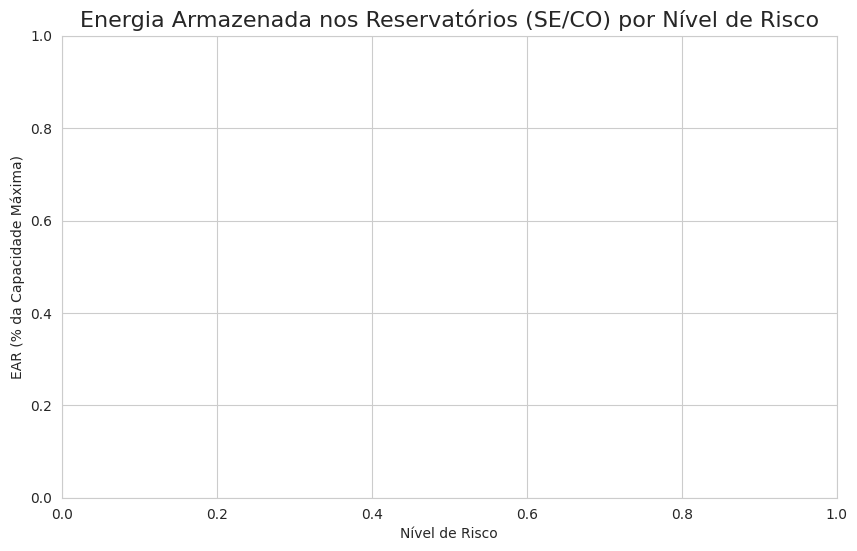

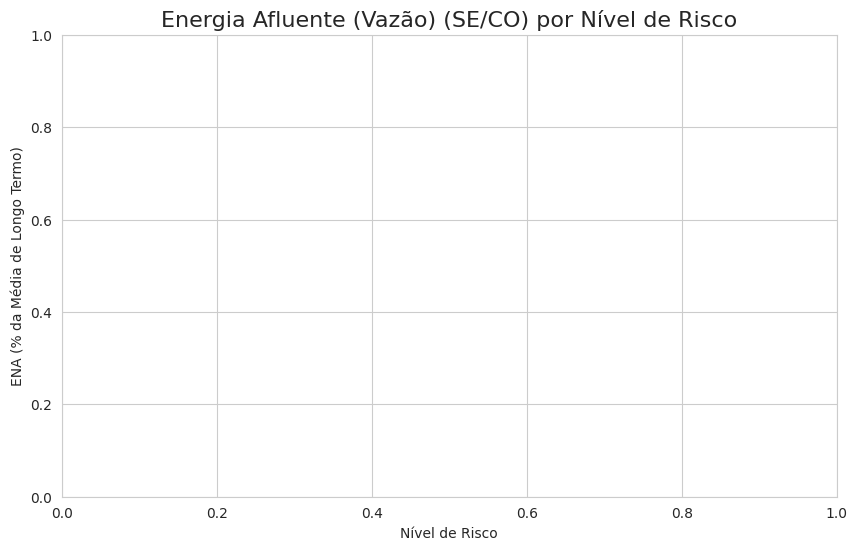

In [6]:
# Gráfico 1: Energia Armazenada (EAR) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ear_percentual_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Energia Armazenada nos Reservatórios (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('EAR (% da Capacidade Máxima)')
plt.xlabel('Nível de Risco')
plt.show()

# Gráfico 2: Energia Afluente (ENA) por Nível de Risco
plt.figure(figsize=(10, 6))
sns.boxplot(x='nivel_risco', y='ena_percentual_mlt_seco', data=df_combinado, order=['baixo', 'medio', 'alto'])
plt.title('Energia Afluente (Vazão) (SE/CO) por Nível de Risco', fontsize=16)
plt.ylabel('ENA (% da Média de Longo Termo)')
plt.xlabel('Nível de Risco')
plt.show()

In [7]:
# --- Célula 7: Salvando a Tabela Final para Modelagem ---

# Define e cria o diretório de saída se não existir
output_path = '../data/processed/feature_table_final.parquet'
output_dir = os.path.dirname(output_path)
os.makedirs(output_dir, exist_ok=True)

# Salva a tabela final, pronta para a fase de Machine Learning
df_combinado.to_parquet(output_path)

print(f"TABELA FINAL PRONTA PARA MODELAGEM salva com sucesso em: {output_path}")
print(f"A tabela contém {df_combinado.shape[0]} dias e {df_combinado.shape[1]} colunas (features + alvo).")

TABELA FINAL PRONTA PARA MODELAGEM salva com sucesso em: ../data/processed/feature_table_final.parquet
A tabela contém 0 dias e 14 colunas (features + alvo).


In [8]:
# --- CÉLULA DE DIAGNÓSTICO DE DATAS ---

print("--- Verificação dos Períodos de Tempo Antes da Junção ---")

print("\nTabela Base (vinda dos notebooks 01 a 04):")
if not df_base.empty:
    print(f"Data inicial: {df_base.index.min()}")
    print(f"Data final:   {df_base.index.max()}")
    print(f"Total de dias: {len(df_base)}")
else:
    print("ERRO: A Tabela base está vazia!")

print("\nTabela de EAR (Energia Armazenada):")
if not df_ear_seco.empty:
    print(f"Data inicial: {df_ear_seco.index.min()}")
    print(f"Data final:   {df_ear_seco.index.max()}")
else:
    print("AVISO: A Tabela EAR está vazia!")

print("\nTabela de ENA (Energia Afluente):")
if not df_ena_seco.empty:
    print(f"Data inicial: {df_ena_seco.index.min()}")
    print(f"Data final:   {df_ena_seco.index.max()}")
else:
    print("AVISO: A Tabela ENA está vazia!")

--- Verificação dos Períodos de Tempo Antes da Junção ---

Tabela Base (vinda dos notebooks 01 a 04):
Data inicial: 2023-01-01 00:00:00
Data final:   2024-01-01 00:00:00
Total de dias: 366

Tabela de EAR (Energia Armazenada):
Data inicial: 2025-01-01 00:00:00
Data final:   2025-10-03 00:00:00

Tabela de ENA (Energia Afluente):
Data inicial: 2025-01-01 00:00:00
Data final:   2025-10-03 00:00:00


In [9]:
print("Valores únicos na coluna 'nom_subsistema' do arquivo EAR:")
print(df_ear_raw['nom_subsistema'].unique())

Valores únicos na coluna 'nom_subsistema' do arquivo EAR:
['NORDESTE' 'NORTE' 'SUDESTE' 'SUL']
